In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.stats import ttest_ind
from dipy.core.sphere import disperse_charges, HemiSphere, Sphere
from dipy.core.gradients import gradient_table
from dipy.data import get_sphere
from dipy.sims.voxel import multi_tensor, multi_tensor_odf
from dipy.viz import window, actor
import nibabel as nib


In [2]:
# Open the file in read mode
with open('real_data/hardi-scheme.bvec.txt', 'r') as file:
    # Read the lines from the file
    lines = file.readlines()

# Initialize an empty matrix to store the values
real_bvecs = []

# Iterate through each line
for line in lines:
    # Split the line into individual values
    values = line.split() 
    # Convert the values to integers and append to the matrix
    real_bvecs.append([float(value) for value in values])

# Convert the list of lists into a 2D NumPy array
real_bvecs = np.array(real_bvecs).T


In [3]:
# Open the file in read mode
with open('real_data/hardi-scheme.bval.txt', 'r') as file:
    # Read the lines from the file
    lines = file.readlines()

# Initialize an empty matrix to store the values
real_bvals = []

# Iterate through each line
for line in lines:
    # Split the line into individual values
    values = line.split() 
    # Convert the values to integers and append to the matrix
    real_bvals.append([float(value) for value in values])

# Convert the list of lists into a 2D NumPy array
real_bvals = np.array(real_bvals).reshape(-1)

In [4]:
gtab = gradient_table(real_bvals, real_bvecs)

In [5]:
mask = nib.load('real_data/mask.nii').get_fdata().astype(bool)
white_mask = nib.load('real_data/white_matter_mask.nii').get_fdata().astype(bool)

hardi_snr10 = nib.load('real_data/DWIS_hardi-scheme_SNR-10.nii').get_fdata()
hardi_snr20 = nib.load('real_data/DWIS_hardi-scheme_SNR-20.nii').get_fdata()
hardi_snr30 = nib.load('real_data/DWIS_hardi-scheme_SNR-30.nii').get_fdata()

In [6]:
print(mask.shape)
print(white_mask.shape)
print(hardi_snr10.shape)
print(hardi_snr20.shape)
print(hardi_snr30.shape)

(50, 50, 50)
(50, 50, 50)
(50, 50, 50, 65)
(50, 50, 50, 65)
(50, 50, 50, 65)


In [7]:
hardi_snr10_masked = hardi_snr10[mask]
hardi_snr20_masked = hardi_snr20[mask]
hardi_snr30_masked = hardi_snr30[mask]
hardi_snr10_masked *= (100/hardi_snr10_masked[0][0])
hardi_snr20_masked *= (100/hardi_snr20_masked[0][0])
hardi_snr30_masked *= (100/hardi_snr30_masked[0][0])

hardi_snr10_white_masked = hardi_snr10[white_mask]
hardi_snr20_white_masked = hardi_snr20[white_mask]
hardi_snr30_white_masked = hardi_snr30[white_mask]
hardi_snr10_white_masked *= (100/hardi_snr10_white_masked[0][0])
hardi_snr20_white_masked *= (100/hardi_snr20_white_masked[0][0])
hardi_snr30_white_masked *= (100/hardi_snr30_white_masked[0][0])

In [8]:
hardi_white_masked_all = np.vstack((hardi_snr10_white_masked, hardi_snr20_white_masked, hardi_snr30_white_masked))
np.random.seed(42)
np.random.shuffle(hardi_white_masked_all)
hardi_white_masked_all

array([[100.        ,  16.68141728,  18.07916501, ...,  45.47868282,
         34.99557482,  33.45439009],
       [100.        ,  59.48667867,  33.93658254, ...,  47.00155644,
         30.4361095 ,  61.85186316],
       [100.        ,   4.21460616,  34.94369335, ...,  25.97735527,
          1.99285867,  11.76183355],
       ...,
       [100.        ,  42.30170598,  43.54686117, ...,  46.70857875,
         51.6891995 ,  49.24161504],
       [100.        ,  44.74013489,  25.11978515, ...,  35.18784143,
          7.30002747,  23.44431898],
       [100.        ,  32.28247932,  31.48289438, ...,  35.86230049,
         12.74147771,  15.92455824]])

In [9]:
S = np.load("synthetic_data/S.npy")
S_noiseless = np.load("synthetic_data/S_noiseless.npy")
F = np.load('synthetic_data/F.npy')
angle_pairs = pd.read_pickle("synthetic_data/angle_pairs.pkl")
S

array([[ 96.71590896,   4.66611714,  32.61520167, ...,  16.34358175,
         29.03217082,  12.84532893],
       [101.70778659,   8.19222904,  15.3739256 , ...,  23.78507279,
         23.49252193,  28.01669923],
       [ 99.0416164 ,  19.01738744,  14.7872993 , ...,  10.50055682,
          7.38763608,  20.03460253],
       ...,
       [103.79594538,   8.05544236,  22.54468078, ...,  15.40619977,
          9.79957699,   6.47732016],
       [101.38343745,  17.06057975,  15.37262382, ...,  20.62772848,
          7.01915072,  15.78139465],
       [121.6597962 ,  18.95888198,  23.65991403, ...,  28.96503781,
         11.09697735,  40.25221029]])

In [10]:
S_sample_rows = np.random.choice(S.shape[0], size= hardi_white_masked_all.shape[0], replace=False)
S_sampled = S[S_sample_rows, :]

real_row_std = np.std(hardi_white_masked_all, axis=1)
synthetic_row_std = np.std(S_sampled, axis=1)

print(f"Mean of standard deviations of real data: {real_row_std.mean():.3f}")
print(f"Mean of standard deviations of synthetic data: {synthetic_row_std.mean():.3f}")

t_statistic, p_value = ttest_ind(real_row_std, synthetic_row_std)
print(f"p-value of t-test between standard deviations: {p_value:.3f}")

Mean of standard deviations of real data: 12.763
Mean of standard deviations of synthetic data: 13.226
p-value of t-test between standard deviations: 0.000


In [11]:
print(f"Standard deviation of standard deviations for different signals - real: {np.std(real_row_std):.3f}")
print(f"Standard deviation of standard deviations for different signals - synthetic: {np.std(synthetic_row_std):.3f}")

Standard deviation of standard deviations for different signals - real: 2.747
Standard deviation of standard deviations for different signals - synthetic: 1.217


In [71]:
real_bvecs_fsphere = np.vstack((real_bvecs[1:], -1 * real_bvecs[1:]))
sphere = Sphere(xyz=real_bvecs_fsphere)

Text(0.5, 0, 'z Label')

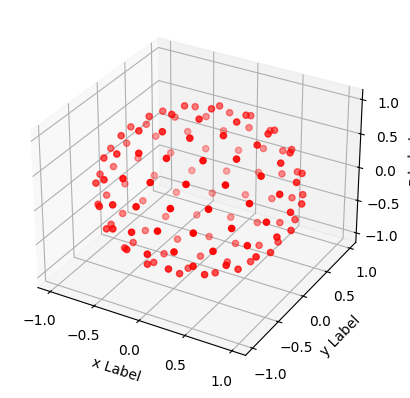

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sphere.vertices[:,0], sphere.vertices[:,1], sphere.vertices[:,2], c='r', marker='o')

# Set labels for each axis
ax.set_xlabel('x Label')
ax.set_ylabel('y Label')
ax.set_zlabel('z Label')

PLOTTING SYNTHETIC NOISELESS DATA

In [85]:
random_samples = np.random.randint(0, len(S)-1, size=10)
evals = result_array = np.tile([0.0015, 0.00045, 0.00045], (len(angle_pairs), 1))

In [116]:
#USING INVERSE SIGNAL AS ODF

for i in random_samples:
    #We have the signal but we need ODF to plot. We take the inverse??? of the signal (since there is less signal in the fiber directions???) to obtain ODF.
    odf_signal = 1 / S_noiseless[i][1:]
    #Keeping the initial sum of the signal the same
    odf_signal *= S_noiseless[i][1:].sum() / odf_signal.sum()
    
    odf_signal_full_sphere = np.hstack((S_noiseless[i][1:], S_noiseless[i][1:]))
    
    odf_actor = actor.odf_slicer(odf_signal_full_sphere[None, None, None, :], sphere=sphere, scale=0.5, colormap='plasma')
    
    #saving the image
    scene = window.Scene()
    odf_actor.display(y=0)
    odf_actor.RotateX(90)
    scene.add(odf_actor)
    window.record(scene, out_path='visualization/noiseless_S/' + str(i) + '_S_noiseless_directly_signal.png', size=(300, 300))

In [87]:
#USING GROUND-TRUTH ANGLES AND FRACTIONS

for i in random_samples:
    odf_gt = multi_tensor_odf(sphere.vertices, evals, angles=angle_pairs,
                                  fractions=100*F[i])
    
    odf_actor = actor.odf_slicer(odf_gt[None, None, None, :], sphere=sphere, scale=0.5, colormap='plasma')
    
    #saving the image
    scene = window.Scene()
    odf_actor.display(y=0)
    odf_actor.RotateX(90)
    scene.add(odf_actor)
    window.record(scene, out_path='visualization/noiseless_S/' + str(i) + '_S_noiseless_w_gt.png', size=(300, 300))

In [118]:
peaks_gt = nib.load('real_data/peaks.nii').get_fdata()

In [119]:
peaks_gt = peaks_gt[white_mask]

In [120]:
peaks_gt

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])